In [1]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

### Data preparation

In this example, we use CIFAR-100.

In [3]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f'x_train_shape: {x_train.shape} - y_train_shape: {y_train.shape}')
print(f'x_test_shape: {x_test.shape} - y_test_shape: {y_test.shape}')

169017344/169001437 [==============================] - 2s 0us/step
x_train_shape: (50000, 32, 32, 3) - y_train_shape: (50000, 1)
x_test_shape: (10000, 32, 32, 3) - y_test_shape: (10000, 1)


### Configure hyper-parameters

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72 # resize input images to this size
patch_size = 6 # size of pathces to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
  projection_dim * 2,
  projection_dim,
] # size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] # size of the dense layers of the final classifier

### Use data augmentation

In [5]:
data_augmentation = keras.Sequential([
  layers.Normalization(),
  layers.Resizing(image_size, image_size),
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(factor=0.02),
  layers.RandomZoom(height_factor=0.2, width_factor=0.2),
], name='data_augmentation')

# Compute the mean and the variance of the training data for normalization, then store them as the layer's weights.
data_augmentation.layers[0].adapt(x_train)

### Implement MLP

In [6]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation=tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

### Implement patch creation as a layer

In [7]:
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID',
    )
    patch_dims = patches.shape[-1] 
    patches = tf.reshape(patches, (batch_size, -1, patch_dims))
    return patches

Image size: 72 x 72
Patch size: 6 x 6
Patches per image: 144
Elements per patch: 108
Var patches shape: (1, 144, 108)


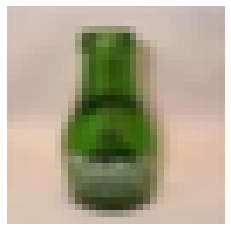

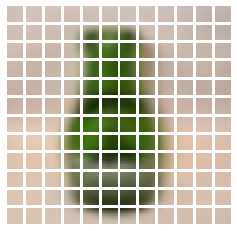

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
  tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} x {image_size}')
print(f'Patch size: {patch_size} x {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}') # patch_size x patch_size x channel
print(f'Var patches shape: {patches.shape}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i + 1)
  patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(patch_img.numpy().astype('uint8'))
  plt.axis('off')